**Basic types of recommendation systems**

1- Demographic filtering: 
They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. The suggestions will have a higher probability of being liked by the average audience.

2- Content-based filtering:
The general idea behind these recommender systems is that if a person likes a particular item, he or she will also like an item that is similar to it.
This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. 

3- Collaborative filtering:
This system matches people with similar interests and provides recommendations based on this matching.

In [1]:
import pandas as pd 
import numpy as np
import ast
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('movies_data/tmdb_5000_credits.csv')

for column in ["cast", "crew"]:
    df1[column] = df1[column].apply(lambda v: ast.literal_eval(v))
    
df1.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de..."
3,49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de..."
4,49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de..."


In [4]:
df1.iloc[0]["cast"][0]

{'cast_id': 242,
 'character': 'Jake Sully',
 'credit_id': '5602a8a7c3a3685532001c9a',
 'gender': 2,
 'id': 65731,
 'name': 'Sam Worthington',
 'order': 0}

In [5]:
df2 = pd.read_csv('movies_data/tmdb_5000_movies.csv')

for column in ["genres", "keywords", "production_companies", "production_countries", "spoken_languages"]:
    df2[column] = df2[column].apply(lambda v: ast.literal_eval(v))
    
list(df2.columns)

['budget',
 'genres',
 'homepage',
 'id',
 'keywords',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'vote_average',
 'vote_count']

In [6]:
print(df2.iloc[0]["genres"][0])
print(df2.iloc[0]["keywords"][0])
print(df2.iloc[0]["spoken_languages"][0])

{'id': 28, 'name': 'Action'}
{'id': 1463, 'name': 'culture clash'}
{'iso_639_1': 'en', 'name': 'English'}


merging the 2 datasets together on "id"

In [7]:
df1.rename(columns={"movie_id": "id"}, inplace=True)
df = df2.merge(df1, how="inner", on="id")
df.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."


**Demographic Filtering**

1- score each movie.

2- sort the scores and recommend the movie with the highest score to all the users.

The average rating is not fair due to the difference in the count of votes ==> we need a weighted average.

We use the IMDB weighted average: 

From ChatGPT:

IMDb's rating system is based on the average rating given to a movie or TV show by registered users of the site. Users can rate titles on a scale of 1 to 10, and the overall rating is then calculated as the weighted average of all the individual ratings. The weighting is designed to ensure that titles with a small number of votes do not skew the overall rating too much. Additionally, IMDb uses a formula to calculate the exact rating, taking into account factors such as the number of votes, the age of votes, and the distribution of ratings. This helps to prevent manipulation of the ratings and ensures a fair representation of the overall opinion of the user base.

a source from 10 years ago :D
The formula is given at the bottom of the Top 250 page.

The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate:

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C where:

v is the number of votes for the movie

m is the minimum votes required to be listed in the chart;

R is the average rating of the movie; 

C is the mean vote across the whole report

In [8]:
# The mean vote for all the movies (from 1 to 10)
C= df['vote_average'].mean()
C

6.092171559442016

In [9]:
# we can use a cut off ==> for example, only consider movies with more votes than at least 90% of all the movies
m= df['vote_count'].quantile(0.9)
m

1838.4000000000015

In [10]:
df_filtered = df.loc[df["vote_count"] >= m]
df_filtered.shape

(481, 23)

In [11]:
def weighted_rating(df):
    v = df['vote_count']
    R = df['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [12]:
df_filtered['score'] = df_filtered.apply(weighted_rating, axis=1)
df_filtered = df_filtered.sort_values('score', ascending=False)
df_filtered.head(10)[["original_title", "score"]]

C:\Users\SandraSukarieh\AppData\Local\Temp\ipykernel_9728\1675928483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['score'] = df_filtered.apply(weighted_rating, axis=1)


,original_title,score
1881,The Shawshank Redemption,8.059258
662,Fight Club,7.939256
65,The Dark Knight,7.920020
3232,Pulp Fiction,7.904645
96,Inception,7.863239
3337,The Godfather,7.851236
95,Interstellar,7.809479
809,Forrest Gump,7.803188
329,The Lord of the Rings: The Return of the King,7.727243
1990,The Empire Strikes Back,7.697884


check the popularity as well

In [13]:
df_popularity = df.sort_values('popularity', ascending=False)
df_popularity.head(10)[["original_title", "popularity"]]

,original_title,popularity
546,Minions,875.581305
95,Interstellar,724.247784
788,Deadpool,514.569956
94,Guardians of the Galaxy,481.098624
127,Mad Max: Fury Road,434.278564
28,Jurassic World,418.708552
199,Pirates of the Caribbean: The Curse of the Bla...,271.972889
82,Dawn of the Planet of the Apes,243.791743
200,The Hunger Games: Mockingjay - Part 1,206.227151
88,Big Hero 6,203.734590


**Content-based Filtering**

The content of the movie is used to calculate its similarity with other movies, then similar movies are recommended.

The "overview" feature can be used in this approach.

In [14]:
df.iloc[0]["overview"]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

The TF-IDF is a good approach that can achieve this goal.

Reminder:

In information retrieval, tf–idf, short for term frequency–inverse document frequency, is a measure of importance of a word to a document in a collection or corpus, adjusted for the fact that some words appear more frequently in general.

The tf–idf is the product of two statistics, term frequency and inverse document frequency.

1- Term frequency, tf(t,d), is the relative frequency of term t within document d: *(term instances/total instances)*

2- The inverse document frequency is a measure of how much information the word provides, i.e., if it is common or rare across all documents: *log(number of documents/documents with term)*

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

df['overview'] = df['overview'].fillna('')

tfidf_matrix = tfidf.fit_transform(df['overview'])

tfidf_matrix.shape

(4803, 20978)

around 20,000 different words were used to describe the 4800 movies in the dataset.

In [16]:
tfidf_matrix

<4803x20978 sparse matrix of type '<class 'numpy.float64'>'
	with 125840 stored elements in Compressed Sparse Row format>

then we use the cosine similarity to calculate the similarity between 2 movies.

Cosine similarity is easy to compute, especially with sparse matrices, and it can capture the overall similarity of the documents regardless of their length. However, it also has some drawbacks. It does not account for the frequency of the words, so it may not reflect the importance of rare or common terms.

to sum-up:

TF-IDF is a way to measure the importance of tokens in text ==> it's way to turn a document into a list of numbers.

To compute cosine similarity, you need two document vectors; the vectors represent each unique term with an index, and the value at that index is the measure of how important that term is to the document.

scikit-learn already provides pairwise metrics that work for both dense and sparse representations of vectors. In this case we need a dot product that is also known as the linear kernel.

In [17]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [18]:
# create a dictionary with the title as a key and the index as a value to use in the recommendation function
title_indices = dict(zip(df["original_title"], df.index))

# create another dictionary with the index as the key and the title as the title
indices_titles = dict((v,k) for k,v in title_indices.items())

def get_content_based_recommendations(title, cosine_sim=cosine_sim):
    # get the index of the movie using the title
    idx = title_indices[title]

    # get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort the movies based on the similarity scores: 
    # the list is a list of tuples where the first item is the index and the second is the similarity with our movie
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # get the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # get the titles of the top 10 most similar movies
    top_similar = [indices_titles[i] for i in movie_indices]

    return top_similar

In [19]:
get_content_based_recommendations('Fight Club')

['UHF',
 'Project X',
 'The Hurt Locker',
 'Raging Bull',
 'The Animal',
 'Blast from the Past',
 'Go for It!',
 'Freaky Deaky',
 'Dancer, Texas Pop. 81',
 'This Is Martin Bonner']

In [20]:
get_content_based_recommendations('Minions')

['Despicable Me 2',
 'Stuart Little 2',
 'The Guilt Trip',
 'Home Alone',
 'Freeway',
 'Darling Companion',
 'The League of Extraordinary Gentlemen',
 'Velvet Goldmine',
 'The Spy Next Door',
 'Wild Wild West']

This can also be enhanced by including more metadata such as the keywords, actors, directors, and the genre.

We can extract those information and build one string for each movie aggregating all of those information. 

However, the tf-idf is not suitable here because we cannot punish actors/directors who worked on a lot of movies. So, we can use

*from sklearn.feature_extraction.text import CountVectorizer*

which converts a collection of text documents to a matrix of token counts. Then the cosine similarity can be used as explained before.

**Collaborative Filtering**

a recommendation approach that takes into account the taste of each user.

1- User based filtering: These systems recommend products to a user that similar users have liked. The similarity between 2 users can be calculated using the pearson correlation/cosine similarity of the 2 users' rates.

This is a very simple, but one main issue is that users’ preference can change over time.

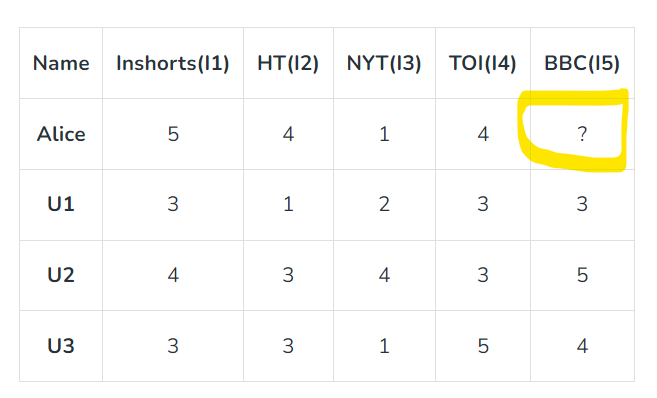

Step 1: Calculating the similarity between Alice and all the other users

At first we calculate the averages of the ratings of all the user ratings excluding I5 as it is not rated by Alice:

r_average(Alice) = (5 + 4 + 1 + 4)/4 = 3.5

r_average(U1) = 2.25

r_average(U2) = 3.5

r_average(U3) = 3

Then we update the rates of the movies using the following formula: r_new(user1, m1) = r(user1, m1) - r_average(user1)

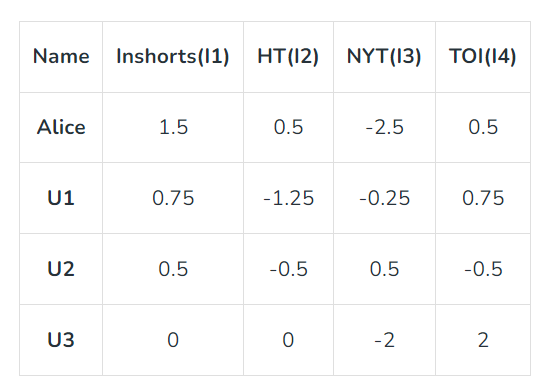

Using this matrix, we can calculate the similarity between Alice and the other users using the cosine similarity between the vectors.

Step 2: Predict Alice's rating for I5 using her similarity scores with the other users ==> weighted average

r(Alice, I5) = r_average(Alice) + (sim(Alice, U1)*r_new(U1, I5) + sim(Alice, U2)*r_new(U2, I5) + sim(Alice, U3)*r_new(U3, I5)) / (sim(Alice, U1) + sim(Alice, U2) + sim(Alice, U3))

r(Alice, I5) = 3.83

=======================================================

2- Item based filtering (first invented and used by Amazon in 1998): We explore the relationship between the pair of items (the user who bought Y, also bought Z). We find the missing rating with the help of the ratings given to the other items by the user.

In other words: rather than matching the user to similar customers, item-to-item collaborative filtering matches each of the user’s purchased and rated items to similar items, then combines those similar items into a recommendation list.

the main issue is scalability. The computation grows with both the customer and the product. 

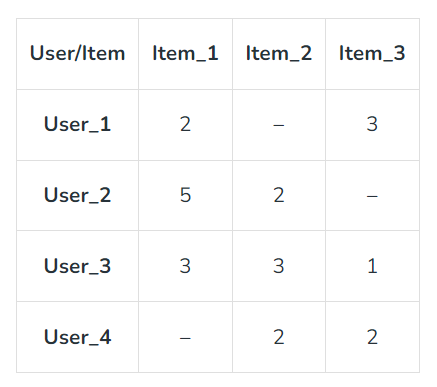

Step 1: Calculate the similarity between items using the cosine similarity:

in this example the item pairs are (Item_1, Item_2), (Item_1, Item_3), and (Item_2, Item_3)

In the table, we can see only User_2 and User_3 have rated for both items 1 and 2. 

==> sim(Item1, Item2) =  0.9

sim(Item1, Item3) = 0.789

sim(Item2, Item3) = 0.869

Step 2: Predict the rating of the missing item using the most similar items already rated by the user

r(User_1, Item_2) = (r(User_1, Item_1)*sim(Item1, Item2) + r(User_1, Item_3)*sim(Item2, Item3)) / (sim(Item1, Item2) + sim(Item2, Item3))

==> r(User_1, Item_2) = 2.49

r(User_2, Item_3) = 3.43

r(User_4, Item_1) = 2